In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [34]:
# 이미지 크기 설정
IMG_SIZE = 100

# 학습 및 테스트 데이터 디렉토리 경로
train_dir = 'faceimage3class/training_set'
test_dir = 'faceimage3class/testing_set'

# 카테고리 설정
categories = ['round', 'square','oblong']

In [35]:
def load_data(data_dir):
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)
        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)

In [36]:
# 학습 데이터 로드
X_train, y_train = load_data(train_dir)

# 테스트 데이터 로드
X_test, y_test = load_data(test_dir)

In [37]:
# 데이터 정규화
X_train = (X_train / 255.0).astype('float32')
X_test = (X_test / 255.0).astype('float32')
# train_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (2399, 100, 100, 3)
Test data shape: (600, 100, 100, 3)


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [33]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 2399 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [38]:
tf.random.set_seed(42)

model = Sequential()

# Conv 레이어 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 레이어 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 레이어 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Dense 레이어
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))  # 얼굴형은 4가지이므로 출력이 4개

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 23, 23, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 10, 10, 128)      

In [39]:
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // 32,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // 32,
#     epochs = 15
# )

Epoch 1/15
75/75 [==============================] - 12s 154ms/step - loss: 1.1332 - accuracy: 0.3977 - val_loss: 1.0133 - val_accuracy: 0.5283
Epoch 2/15
75/75 [==============================] - 12s 158ms/step - loss: 0.9878 - accuracy: 0.5231 - val_loss: 0.9585 - val_accuracy: 0.5367
Epoch 3/15
75/75 [==============================] - 12s 165ms/step - loss: 0.9315 - accuracy: 0.5798 - val_loss: 0.9456 - val_accuracy: 0.5333
Epoch 4/15
75/75 [==============================] - 13s 169ms/step - loss: 0.8733 - accuracy: 0.6040 - val_loss: 0.9469 - val_accuracy: 0.5633
Epoch 5/15
75/75 [==============================] - 12s 162ms/step - loss: 0.8668 - accuracy: 0.6178 - val_loss: 0.9423 - val_accuracy: 0.5350
Epoch 6/15
75/75 [==============================] - 12s 160ms/step - loss: 0.8152 - accuracy: 0.6436 - val_loss: 0.8677 - val_accuracy: 0.5933
Epoch 7/15
75/75 [==============================] - 12s 164ms/step - loss: 0.7604 - accuracy: 0.6603 - val_loss: 0.8648 - val_accuracy: 0.6083

In [40]:
# 예측값 생성
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

19/19 [==============================] - 1s 35ms/step


In [41]:
# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[158  27  15]
 [ 60 108  32]
 [ 35  25 140]]


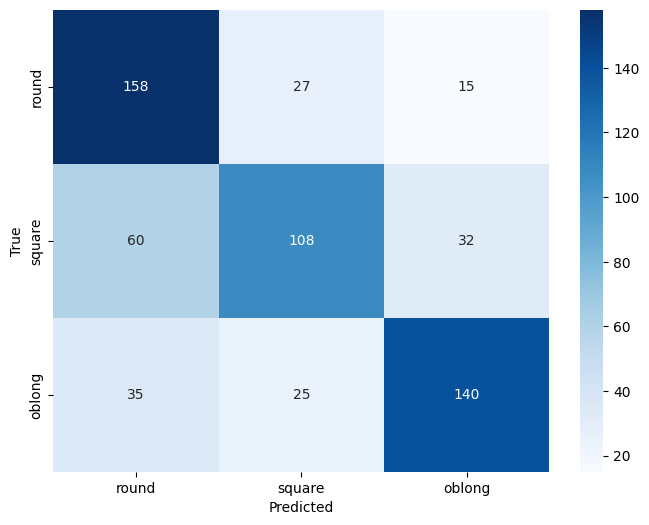

In [42]:
# 시각화
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [43]:
# 클래스별 성능 평가
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=categories))

Classification Report:
              precision    recall  f1-score   support

       round       0.62      0.79      0.70       200
      square       0.68      0.54      0.60       200
      oblong       0.75      0.70      0.72       200

    accuracy                           0.68       600
   macro avg       0.68      0.68      0.67       600
weighted avg       0.68      0.68      0.67       600



In [44]:
# 테스트 데이터로 모델 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

19/19 [==============================] - 1s 36ms/step - loss: 0.9797 - accuracy: 0.6767
Test accuracy: 0.6766666769981384


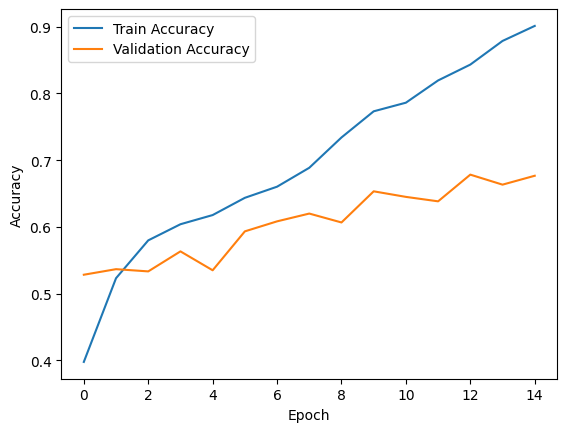

In [45]:
# 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

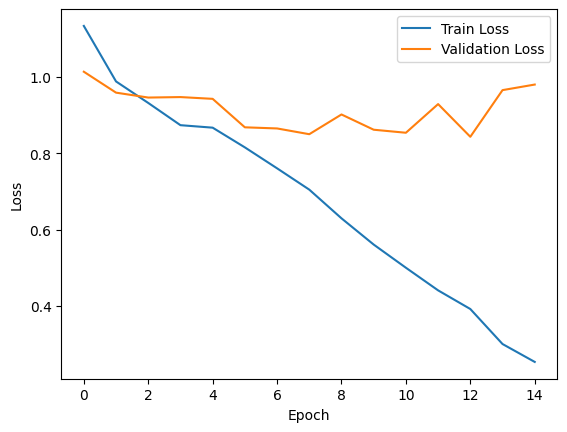

In [46]:
# 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [167]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:

# 데이터 증강을 위한 ImageDataGenerator 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,           # 픽셀값을 0-1 범위로 스케일링
    width_shift_range=0.2,    # 수평 이동
    height_shift_range=0.2,   # 수직 이동
    shear_range=0.2,          # 전단 변환
    # zoom_range=0.2,           # 확대/축소
    horizontal_flip=True,      # 수평 반전
    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest'       # 변환된 픽셀을 채우는 방법
)

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)  # 테스트 데이터는 증강하지 않음

In [205]:
# 학습 및 테스트 데이터 디렉토리 경로
train_dir = 'faceimage/training_set'
test_dir = 'faceimage/testing_set'

In [20]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='sparse'
)

Found 2399 images belonging to 3 classes.


In [21]:
# Conv 레이어 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 레이어 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 레이어 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten
model.add(Flatten())

# Dense 레이어
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))  # 얼굴형은 5가지이므로 출력이 5개

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 출력
model.summary()

ValueError: Input 0 of layer "conv2d_3" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 5)

In [249]:
from PIL import ImageFile
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [250]:
# 이미지 파일 경로를 순회하며 손상된 파일 확인 및 제거
folder_path = 'faceimage/training_set'  # 데이터셋 경로
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # 이미지 파일 검증
        except (IOError, SyntaxError) as e:
            print(f"손상된 이미지 파일: {file_path}, 제거합니다.")
            os.remove(file_path)  # 손상된 파일 제거

In [251]:
# 이미지 파일 경로를 순회하며 손상된 파일 확인 및 제거
folder_path = 'faceimage/testing_set'  # 데이터셋 경로
for root, dirs, files in os.walk(folder_path):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # 이미지 파일 검증
        except (IOError, SyntaxError) as e:
            print(f"손상된 이미지 파일: {file_path}, 제거합니다.")
            os.remove(file_path)  # 손상된 파일 제거

In [22]:
# ImageDataGenerator로 이미지 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # 이미지 회전
    width_shift_range=0.2,      # 수평 이동
    height_shift_range=0.2,     # 수직 이동
    # shear_range=0.2,            # 전단 변환
    # zoom_range=0.2,             # 확대
    horizontal_flip=True,       # 수평 뒤집기
    fill_mode='nearest'         # 변환 시 생기는 빈 공간 채우기
    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [23]:
# 훈련 및 테스트 세트 생성
train_generator = train_datagen.flow_from_directory(
    'faceimage3class/training_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'faceimage3class/testing_set',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 2399 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [265]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [24]:
model = Sequential()

# conv2d 레이어 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2d 레이어 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Conv 레이어 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [239]:
for x_batch, y_batch in train_generator:
    try:
        model.train_on_batch(x_batch, y_batch)
    except OSError as e:
        print(f"오류 발생: {e}, 이미지 건너뜀")
        continue

OSError: image file is truncated (8 bytes not processed)

In [247]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [257]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [25]:
# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/20


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "c:\shson\anaconda3\envs\newenv\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\shson\anaconda3\envs\newenv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\shson\anaconda3\envs\newenv\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\shson\anaconda3\envs\newenv\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\shson\anaconda3\envs\newenv\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\shson\AppData\Local\Temp\ipykernel_10576\180571007.py", line 2, in <module>
      history = model.fit(
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "c:\shson\anaconda3\envs\newenv\lib\site-packages\keras\src\backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[32,5] labels_size=[32,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_9709]

In [272]:
# 모델 평가
loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

32/32 [==============================] - 6s 173ms/step - loss: 1.5611 - accuracy: 0.3300
Test Accuracy: 33.00%


In [47]:
# 모델 저장
model.save('face_shape_cnn_model.keras')